In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from datasets import Dataset

from sklearn.metrics import roc_auc_score, roc_curve

from transformers import enable_full_determinism

from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.losses import TripletLoss, TripletDistanceMetric


d:\Documents\nsu\ruArgMiner\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42
NUM_UNFROZEN_TRANSFORMER_LAYERS = 8
NUM_EPOCHS = 1
BATCH_SIZE = 8
TRIPLET_DATASET_DIR = Path('../datasets/similarity_learning/1ctx_transitive')
RANDOM_PAIR_DATASET_DIR = Path('../datasets/random_pairs/1ctx')


In [3]:
enable_full_determinism(RANDOM_STATE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device "{device}"')


Using device "cuda"


In [4]:
train_dataset = Dataset.load_from_disk(TRIPLET_DATASET_DIR / 'train')
eval_dataset  = Dataset.load_from_disk(TRIPLET_DATASET_DIR / 'eval')
test_dataset  = Dataset.load_from_disk(TRIPLET_DATASET_DIR / 'test')


In [5]:
def prepare_dataset(data: Dataset):
    anchors = [f'{row["anchor_left"]}. {row["anchor"]}. {row["anchor_right"]}' for row in data]
    positives = [f'{row["positive_left"]}. {row["positive"]}. {row["positive_right"]}' for row in data]
    negatives = [f'{row["negative_left"]}. {row["negative"]}. {row["negative_right"]}' for row in data]
    dataset_dict = { 'anchor': anchors, 'positive': positives, 'negative': negatives }
    return Dataset.from_dict(dataset_dict)

train_dataset_tok = prepare_dataset(train_dataset)
eval_dataset_tok = prepare_dataset(eval_dataset)
test_dataset_tok = prepare_dataset(test_dataset)


In [6]:
model = SentenceTransformer('ai-forever/ru-en-RoSBERTa', similarity_fn_name='cosine')
model[0].auto_model.requires_grad_(False)
for i in range(NUM_UNFROZEN_TRANSFORMER_LAYERS):
    model[0].auto_model.encoder.layer[-1 - i].requires_grad_(True)
model[0].auto_model.pooler.requires_grad_(True)
model.to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [7]:
training_args = SentenceTransformerTrainingArguments(
    output_dir='trainer_output',
    report_to='none',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy='steps',
    eval_steps=512,
    logging_steps=512,
    save_steps=512,
    save_total_limit=3,
    learning_rate=1e-5,
    warmup_ratio=0.1,
    fp16=True,
    load_best_model_at_end=True,
)

trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tok,
    eval_dataset=eval_dataset_tok,
    loss=TripletLoss(model, TripletDistanceMetric.COSINE, 0.2),
)


In [8]:
trainer.train()


Step,Training Loss,Validation Loss
512,0.093200,0.100999
1024,0.084700,0.099836
1536,0.082600,0.098934
2048,0.080000,0.096589
2560,0.073800,0.097648
3072,0.073100,0.097066
3584,0.067100,0.097314
4096,0.069700,0.096424


TrainOutput(global_step=4295, training_loss=0.07743057854933288, metrics={'train_runtime': 6333.2934, 'train_samples_per_second': 5.425, 'train_steps_per_second': 0.678, 'total_flos': 0.0, 'train_loss': 0.07743057854933288, 'epoch': 1.0})

In [9]:
random_eval_dataset  = Dataset.load_from_disk(RANDOM_PAIR_DATASET_DIR / 'eval')
random_eval_premises = [f'{row["fragment1_left"]}. {row["fragment1"]}. {row["fragment1_right"]}' for row in random_eval_dataset]
random_eval_conclusions = [f'{row["fragment2_left"]}. {row["fragment2"]}. {row["fragment2_right"]}' for row in random_eval_dataset]


In [10]:
eval_similarities = model.similarity_pairwise(model.encode(random_eval_premises), model.encode(random_eval_conclusions))
eval_labels = random_eval_dataset['related']
fpr, tpr, _ = roc_curve(eval_labels, eval_similarities)
auc = roc_auc_score(eval_labels, eval_similarities)
j_fpr, j_tpr = max(*zip(fpr, tpr), key=lambda z: 1 - z[0] + z[1])


Specificity = 0.8285
Sensitivity = 0.7863
ROC-AUC     = 0.8600


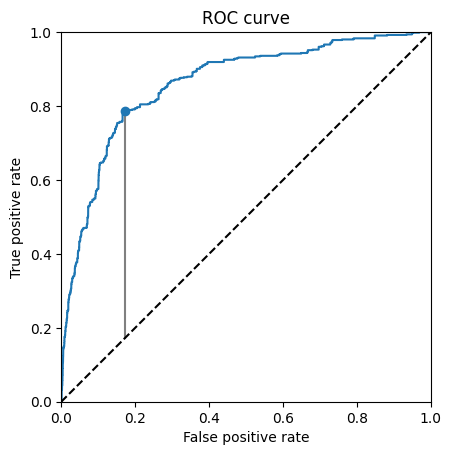

In [11]:
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.plot(fpr, tpr)
ax.plot([j_fpr, j_fpr], [j_tpr, j_fpr], color='grey')
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.scatter([j_fpr], [j_tpr], zorder=2)
ax.set_title('ROC curve')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

print(f'Specificity = {1 - j_fpr:0.4f}')
print(f'Sensitivity = {j_tpr:0.4f}')
print(f'ROC-AUC     = {auc:0.4f}')
